<a href="https://colab.research.google.com/github/HectorMaravillo/StreetNetworks/blob/main/Beta_Skeletons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **$\beta$-esqueletos de una red de calles**

Author: Héctor Maravillo

e-mail: hector.maravillo@im.unam.mx

Instituto de Matemáticas Unidad Cuernavaca, UNAM

Abril 2022

-------------------------------------------

## **Importación de librerías**

In [ ]:
# En caso de no tener instaladas las librerías, eliminar el simbolo "#" y cargar
#!pip install --upgrade pyshp
#!pip install --upgrade rtree
#!pip install --upgrade pygeos
#!pip install --upgrade shapely
#!pip install --upgrade descartes
#!pip install --upgrade geopandas
#!pip install --upgrade osmnx
#!pip install --upgrade matplotlib

In [ ]:
%matplotlib inline

In [ ]:
# Librerías
import numpy as np                        # Cálculo numérico y análisis de datos
import geopandas as gpd                   # Análisis de datos geográficos
import matplotlib.pyplot as plt           # Construcción de gráficas
import osmnx as ox                        # Extracción de redes de vialidades de OpenStreetMap
import networkx as nx                     # Construcción y análisis de gráficas y digráficas

# Herramientas
from shapely.geometry import Point        # Puntos en el plano
from shapely.geometry import MultiPoint   # Multipuntos en el plano
from itertools import combinations        # Combinaciones de un conjunto

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Extracción de la red de vialidades de OpenStreetMaps

In [ ]:
def Extract_StreetNetwork(city_name, distance, draw_map = False):
  """ función para extraer y graficar la red de calles de una ciudad.
  Se elige el nombre del centro de una ciudad y una distancia que define un cuadrado
  de donde se extraerá la red """
  # Extracción de la red de vialidades (representación geográfica) en formato de gráfica de networkx
  G = ox.graph_from_address(city_name, dist = distance, truncate_by_edge = True, network_type = "drive")                          
  # Graficar mapa
  if draw_map == True:
    G_stats = "nodos: " + str(G.order()) + "  aristas: " + str(G.size())
    fig, ax = ox.plot_graph(G, figsize = (5,5), show = False, close = False)            # Mapa simple
    ax.set_title(city_name + "\n" + G_stats)
    plt.show()
  return G                      

In [ ]:
Mérida = Extract_StreetNetwork("Mérida, Yucatán", 1000)

In [ ]:
Puebla = Extract_StreetNetwork("Puebla, Puebla", 1000)

In [ ]:
Cuernavaca = Extract_StreetNetwork("Cuernavaca, Morelos", 1000)

In [ ]:
Guanajuato = Extract_StreetNetwork("Guanajuato, Guanajuato", 1000)

In [ ]:
CerroJudio = Extract_StreetNetwork("Cerro del Judio,Ciudad de México", 1000)

In [ ]:
BosquesLomas = Extract_StreetNetwork("Colonia Bosques de las Lomas, Miguel Hidalgo,Ciudad de México", 1000)

## **Construcción de $\beta$-esqueletos**

Se grafican las redes de calles de algunas zonas, y se construyen beta-esqueletos para diferentes valores de beta. 

Para comparar la aproximación se muestran las aristas en la intersección y la diferencia simétrica de ambas gráficas. También se muestran los valores de las razones propuestas en Osaragi, Hiraga (2014) *Street network created by proximity graphs, its topological structure and travel efficiency*, estas razones son:

$\text{C-Rate} = \frac{m(H\cap G)}{m(H\cup G)}$

$\text{R-Rate} = \frac{m(H\cap G)}{m(H)}$

$\text{G-Rate} = \frac{m(H\cap G)}{m( G)}$

donde $G$ corresponde a la gráfica de la red de calles, $H$ al beta-esqueleto y $m(G)$ al número de aristas de la gráfica $G$.

In [ ]:
def Circle(c, r):
  """ Función para construir un conjunto de puntos sobre una circunferencia,
  a partir de un centro y un radio """
  t      = np.linspace(0, 2*np.pi,100)  # Crea un conjunto de valores de la variable t que parametriza la circunferencia
  x      = c[0] + r*np.cos(t)           # Función paramétrica de un circunferencia dado un centro y un radio 
  y      = c[1] + r*np.sin(t)
  circle = np.vstack((x, y)).T          # Agrupa las cordenadas x,y de la circunferencia        
  del x,y,t
  return circle

def Extract_Points(G):
  """
  Función para extrae los n vértices de una red G y devuelve una matriz 2xn con sus coordenadas
  """
  p = []
  for v in G.nodes(data=True):          # Itera sobre todos los vértices de una gráfica y sus atributos
    p.append((v[1]["x"], v[1]["y"]))    # Extrae las coordenadas de cadavértice
  points = np.array(p)
  del p
  return points

def lune_region(u,v,beta):
  """ Función para construir la región de intersección de los beta-esqueletos.
  Devuelve el centro de cada circulo y su radio.
  Véase Alonso, L., Méndez-Bermúdez, J.A., Estrada, E., (2021) para la definción de la región"""
  d = np.linalg.norm(u-v)               # Distancia en el plano entre dos vértices u,v
  if beta >= 1:
    beta_aux = beta/2
    r = beta_aux*d
    c1 = u*beta_aux + (1-beta_aux)*v
    c2 = v*beta_aux + (1-beta_aux)*u
  elif beta>0:
    r = d/(2*beta)
    R      = np.array([[0,-1],[1,0]] )
    c1 = (u+v)/2 + np.dot(R,v-u)*np.power(1-np.power(beta,2), 0.5)/(2*beta)
    c2 = (u+v)/2 - np.dot(R,v-u)*np.power(1-np.power(beta,2), 0.5)/(2*beta)
  return {"c1": c1, "c2": c2, "r": r}

def Beta_Skeleton(G, beta, type="lune-based"):
  """ Función para construir el beta-esqueleto de una red"""
  H      = nx.create_empty_copy(G, with_data=True)                            # Crea una copia de la red sin aristas
  for pair in combinations(G.nodes(),2):                                      # Itera sobre todos los pares de vértices u,v
    u            = np.array([G.nodes[pair[0]]["x"], G.nodes[pair[0]]["y"]])
    v            = np.array([G.nodes[pair[1]]["x"], G.nodes[pair[1]]["y"]])
    if type == "lune-based":                                                  # Beta-esqueletos basados en lunas
      search_region = lune_region(u,v, beta)                                  # Devuelve el centro c1 y c2 y el radio que define la región vacia
    empty_test   = True                                                      
    for z in G.nodes():            
      if z not in set(pair):                                                  # Itera sobre todos los vértices z diferentes al par u,v
        z_coord    = np.array([G.nodes[z]["x"], G.nodes[z]["y"]])             # Extrae coordenadas del vértice z
        dist_1     = np.linalg.norm(z_coord-search_region["c1"])              # Distancia en el plano entre z y el centro 1
        dist_2     = np.linalg.norm(z_coord-search_region["c2"])              # Distancia en el plano entre z y el centro 2
        if dist_1 <= search_region["r"] and dist_2 <= search_region["r"]:     # Comprueba que z se encuentre en la región de intersección (basado en lunas)
          empty_test =False
          break
    if empty_test  == True:                                                   
      H.add_edge(pair[0], pair[1])                                            # Si la región de intersección está vacia agrega una arista entre u,v
  ox.distance.add_edge_lengths(H)

  # Comparar gráfica original y beta-esqueleto
  G_stats = "n: " + str(G.order()) + "  m: " + str(G.size())
  H_stats = "n: " + str(H.order()) + "  m: " + str(H.size())
  # Convertir digráficas en gráficas (no dirigidas)
  G_undirected = G.to_undirected()                                          
  H_undirected = H.to_undirected()
  # Construir gráfica de intersección
  intersection = nx.intersection(G_undirected, H_undirected)
  intersection.graph = G.graph
  ox.distance.add_edge_lengths(intersection)
  # Construir gráfica de la diferencia simétrica
  sim_diff = nx.symmetric_difference(G_undirected, H_undirected)
  sim_diff.graph = G.graph
  ox.distance.add_edge_lengths(sim_diff)
  # Construir gráfica de la unión
  union = nx.compose(G_undirected, H_undirected)
  # Calcular razones de comparación (Véase Osaragi, Hiraga (2014))
  c_ratio = intersection.size() / union.size()
  r_ratio = intersection.size() / H_undirected.size()
  g_ratio = intersection.size() / G_undirected.size()
  ratios = "C-ratio: " + "{0:.3f}".format(c_ratio) + "\nR-ratio: " + "{0:.3f}".format(r_ratio)  + "\nG-ratio: " +"{0:.3f}".format(g_ratio)

  # Grafica la red original y el beta esqueleto
  fig, ax = plt.subplots(figsize = (15,15), nrows = 1, ncols = 5)
  ox.plot_graph(G, ax = ax[0], node_color = "black", edge_color = "black", show=False)
  ox.plot_graph(H, ax = ax[1], node_color = "black", edge_color = "red", show=False)      
  ax[0].title.set_text('Street network\n' + G_stats)
  if beta == 1:
    ax[1].title.set_text('Gabriel Graph (Beta=1)\n' + H_stats) 
  elif beta == 2:
    ax[1].title.set_text('Relative Neighbourhood Graph (Beta=2)\n' + H_stats) 
  else:
    ax[1].title.set_text('Beta-Skeleton (Beta='+str(beta)+')\n' + H_stats) 
  ox.plot_graph(intersection, ax = ax[2], node_color = "black", edge_color = "red", show=False)  
  ax[2].title.set_text('Intersection')
  ox.plot_graph(sim_diff, ax = ax[3], node_color = "black", edge_color = "red", show=False)
  ax[3].title.set_text('Symmetric difference')
  ax[4].set_axis_off()
  ax[4].text(0.5, 0.5, ratios)
  ax[4].set_aspect('equal', adjustable='box')
  plt.show()
  return H

betas_iterar = [0.1, 0.9, 1, 1.2, 1.4, 1.6, 2, 5]

### **Ejemplo: Centro de Mérida (1km), Yucatán**

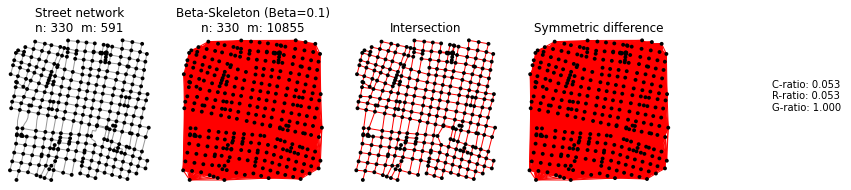

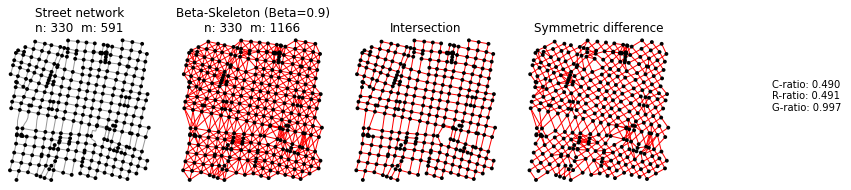

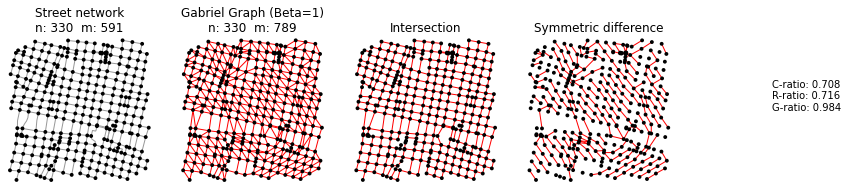

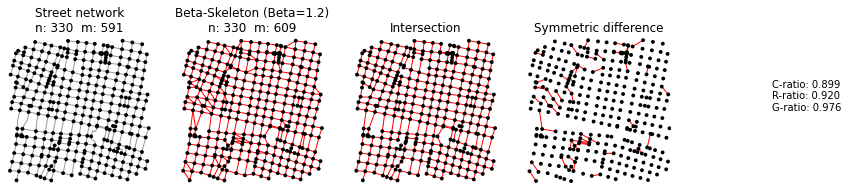

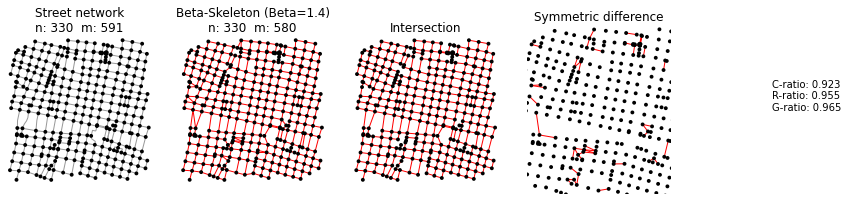

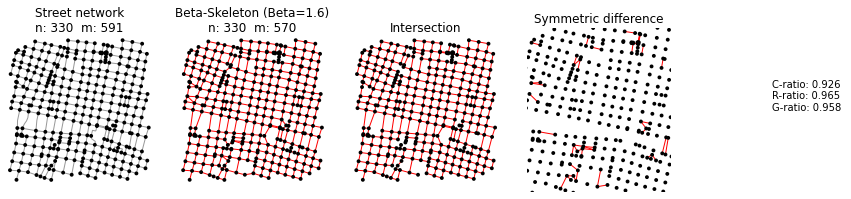

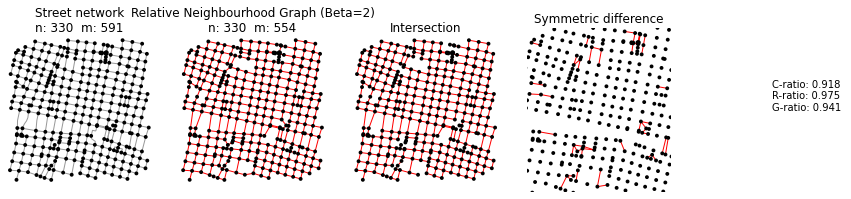

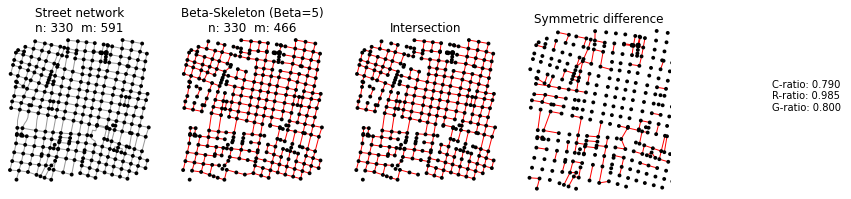

In [ ]:
for i in betas_iterar:
  H = Beta_Skeleton(Mérida, i)

### **Ejemplo: Centro de Puebla (1km), Puebla**

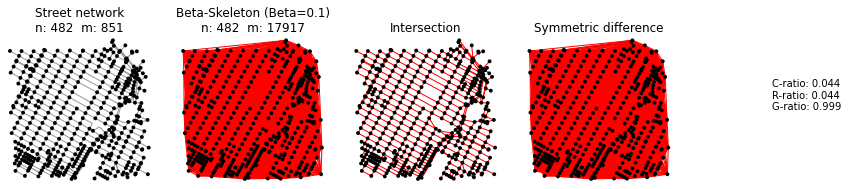

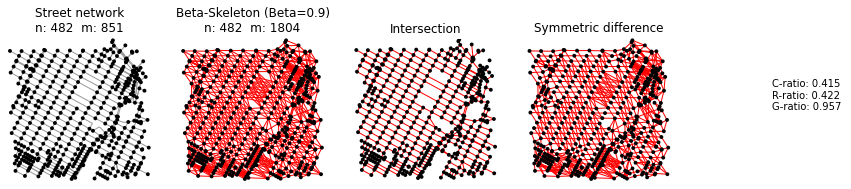

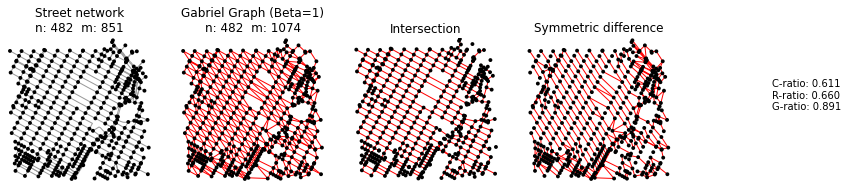

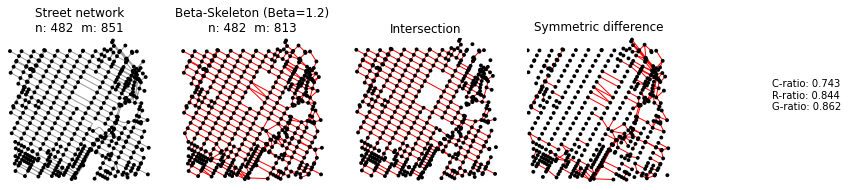

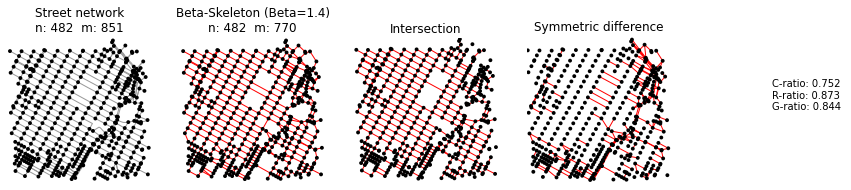

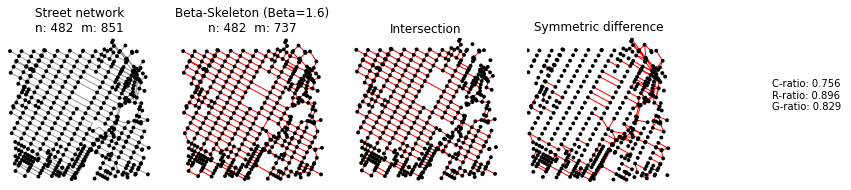

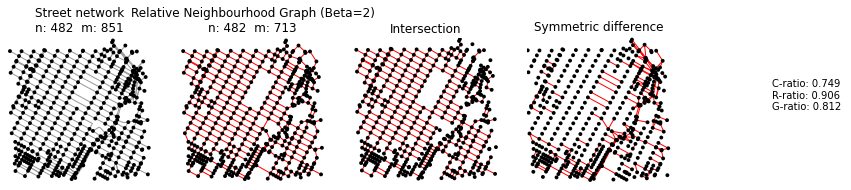

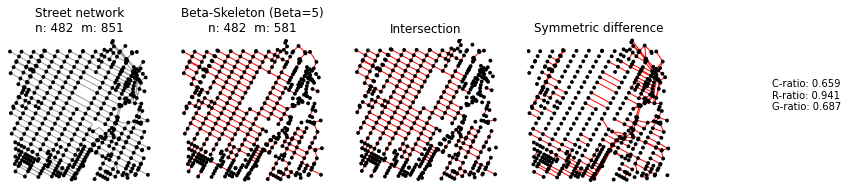

In [ ]:
for i in betas_iterar:
  H = Beta_Skeleton(Puebla, i)

### **Ejemplo: Centro de Cuernavaca (1km), Morelos**

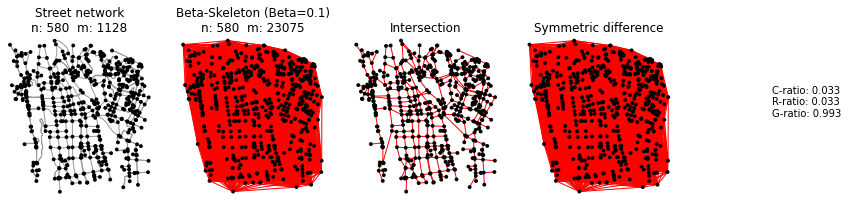

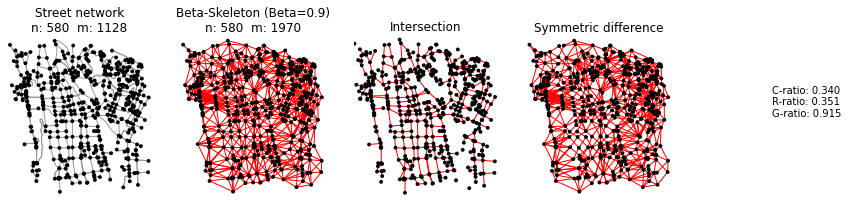

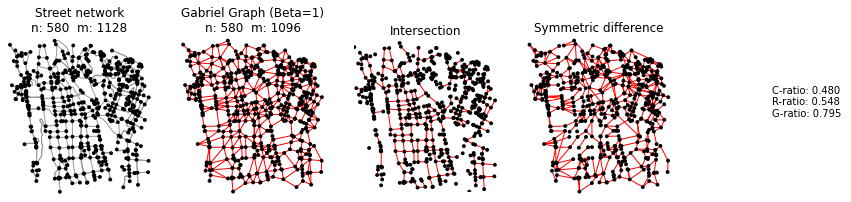

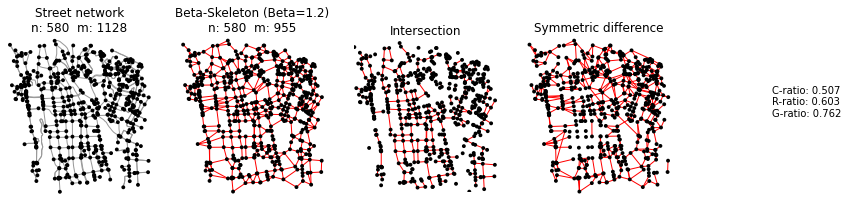

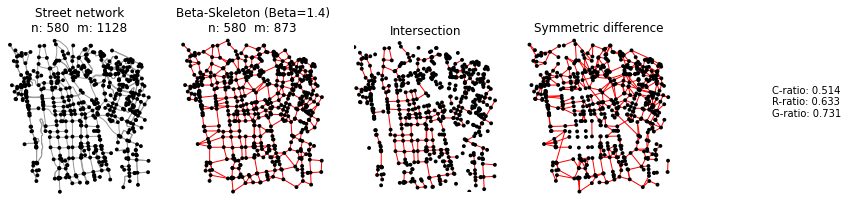

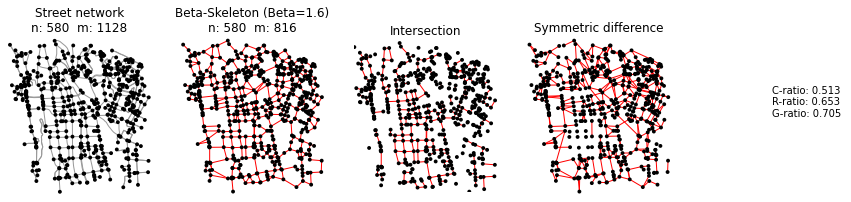

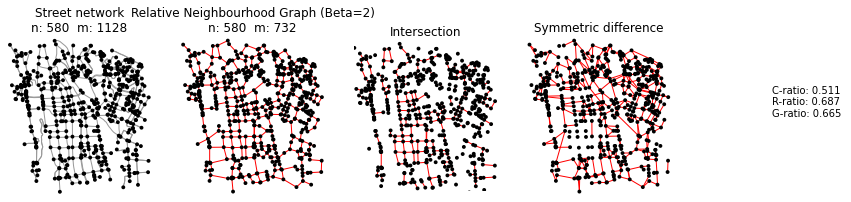

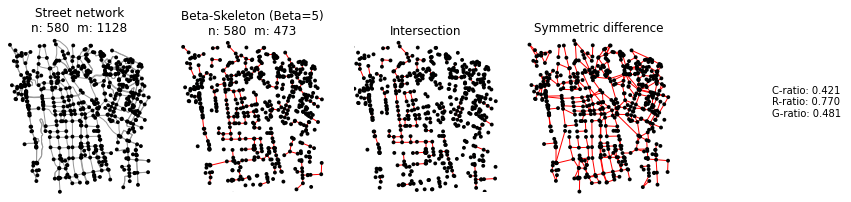

In [ ]:
for i in betas_iterar:
  H = Beta_Skeleton(Cuernavaca, i)

### **Ejemplo: Centro de Guanajuato (1km), Guanajuato**

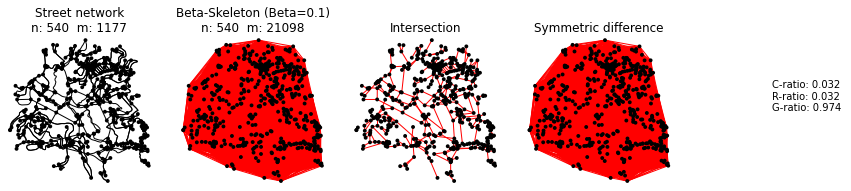

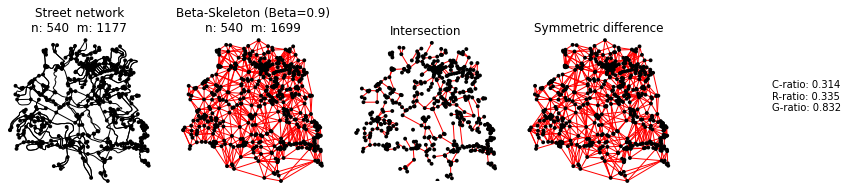

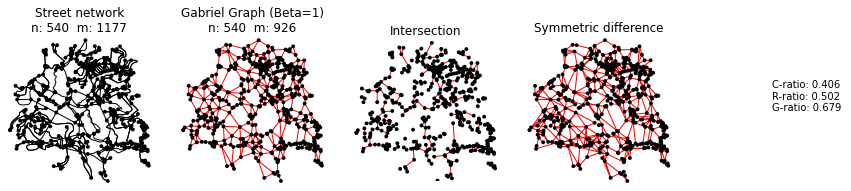

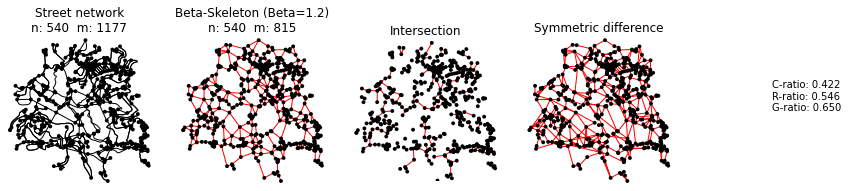

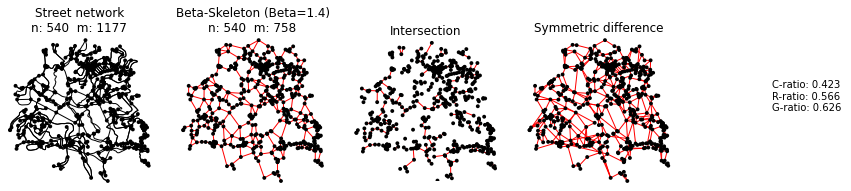

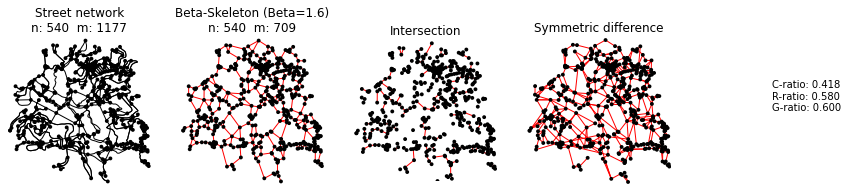

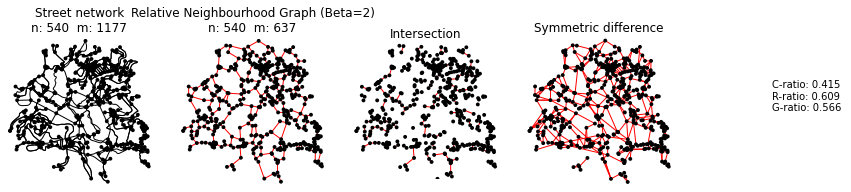

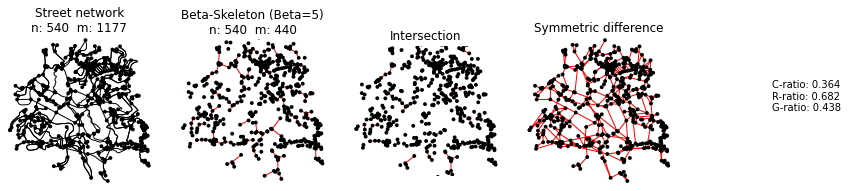

In [ ]:
for i in betas_iterar:
  H = Beta_Skeleton(Guanajuato, i)

### **Ejemplo: Cerro del Judío (1km), La Magadalena Contreras, Ciudad de México**

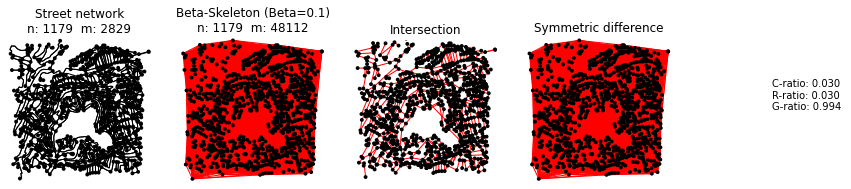

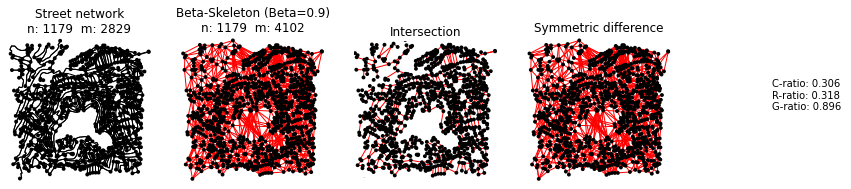

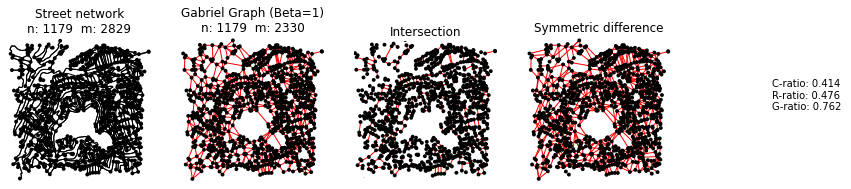

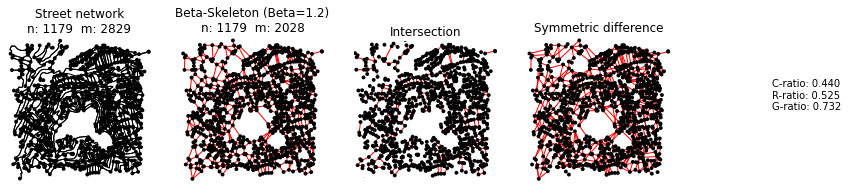

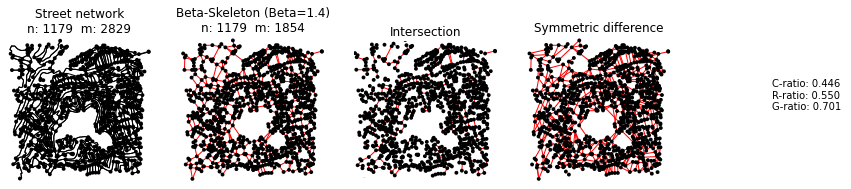

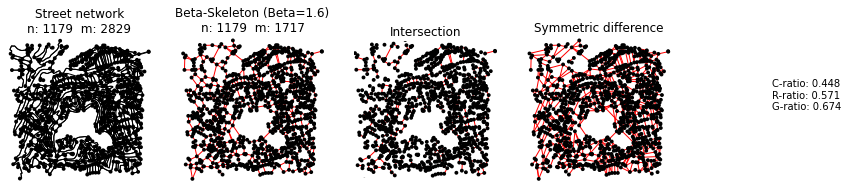

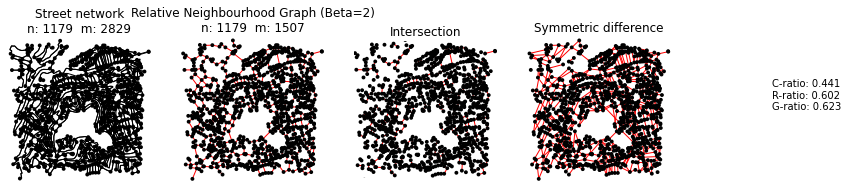

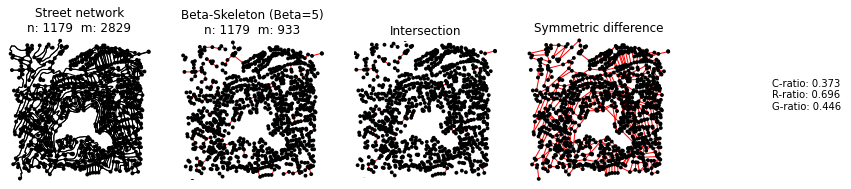

In [ ]:
for i in betas_iterar:
  H = Beta_Skeleton(CerroJudio, i)

### **Ejemplo: Bosque de las Lomas (1km), Miguel Hidalgo, Ciudad de México**

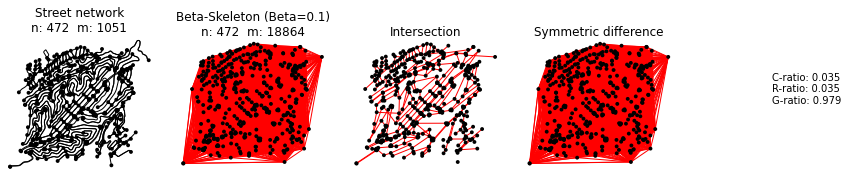

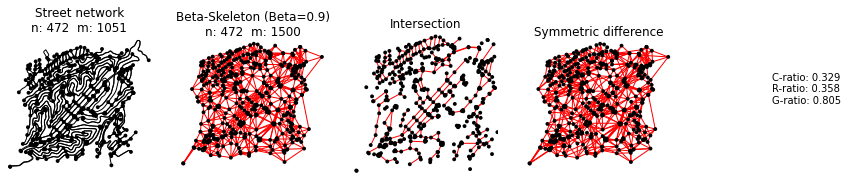

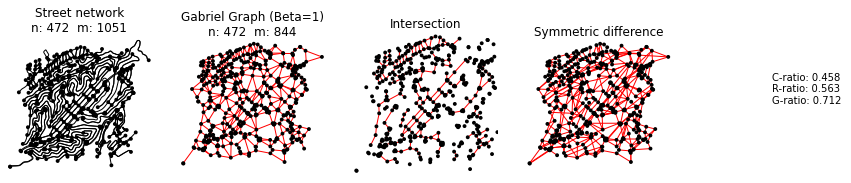

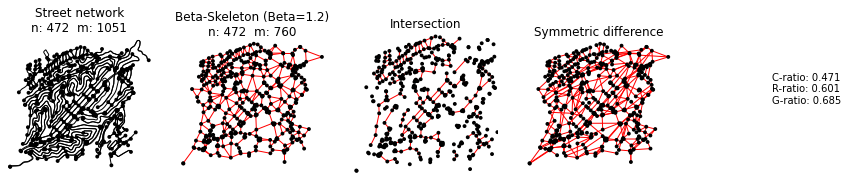

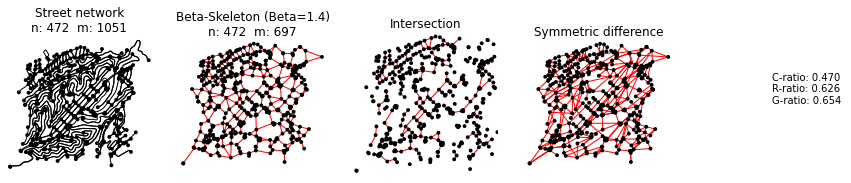

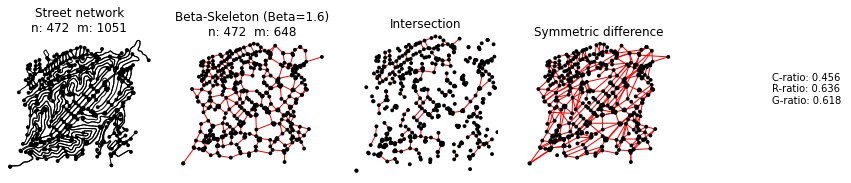

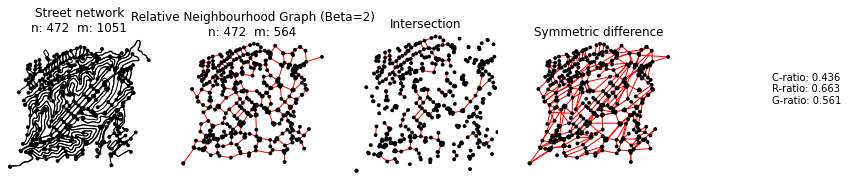

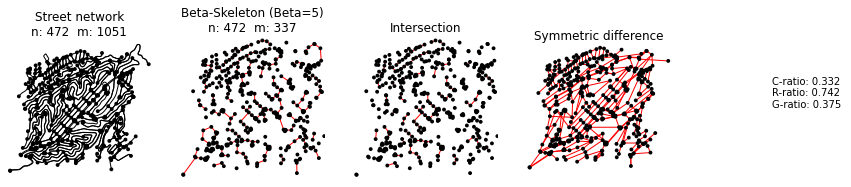

In [ ]:
for i in betas_iterar:
  H = Beta_Skeleton(BosquesLomas, i)